# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import os
import glob

from joblib import Parallel, delayed
from matplotlib.colors import rgb2hex
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import screed
import seaborn as sns
from tqdm import tqdm


import predictorthologs_utils as po_utils

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100

## Set figure folder

In [2]:
FIGURE_FOLDER = '/home/olga/googledrive/ImmuneEvolution/figures'
figure_folder = os.path.join(FIGURE_FOLDER, 'sankey_plots')
! mkdir -p $figure_folder

## Constants

In [3]:
CELLTYPE_COL = 'broad_group'

### Kmermaid outdir for each species

## `def describe`

In [4]:
def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

## Set shared celltypes

Cells previously shown to be shared across mouse, human, and bat 

In [5]:
SHARED_CELLTYPES = [
    "Capillary",
    "Alveolar Epithelial Type 2",
    "B cell",
    "T cell",
    "Natural Killer T cell",
    "Macrophage",
    "Monocyte",
    "Dendritic",
    "Fibroblast",
    "Smooth Muscle and Myofibroblast",
]

BROAD_TO_COMPARTMENT = pd.Series({
    "Capillary": "endothelial",
    "Artery": "endothelial",
    "Vein": "endothelial",
    "Alveolar Epithelial Type 2": "epithelial",
    "T cell": "lymphoid",
    "B cell": "lymphoid",
    "Natural Killer T cell": "lymphoid",
    "Natural Killer": "lymphoid",
    "Monocyte": "myeloid",
    "Macrophage": "myeloid",
    "Dendritic": "myeloid",
    "Neutrophil": "myeloid",
    "Fibroblast": "stromal",
    "Smooth Muscle and Myofibroblast": "stromal",
})
broad_to_compartment = BROAD_TO_COMPARTMENT[SHARED_CELLTYPES]
broad_to_compartment

Capillary                          endothelial
Alveolar Epithelial Type 2          epithelial
B cell                                lymphoid
T cell                                lymphoid
Natural Killer T cell                 lymphoid
Macrophage                             myeloid
Monocyte                               myeloid
Dendritic                              myeloid
Fibroblast                             stromal
Smooth Muscle and Myofibroblast        stromal
dtype: object

In [6]:
compartment_colors = sns.color_palette("Set2", broad_to_compartment.nunique())
compartment_colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)]

In [7]:
type(compartment_colors)

seaborn.palettes._ColorPalette

In [8]:
compartment_to_color = dict(zip(sorted(broad_to_compartment.unique()), compartment_colors))
compartment_to_color

{'endothelial': (0.4, 0.7607843137254902, 0.6470588235294118),
 'epithelial': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'lymphoid': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'myeloid': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'stromal': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)}

# Read aggregated cell type similarites

## file paths

In [9]:
sig_outdir_base = "/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures"

top_hit_suffix = os.path.join(
    "4--aggregated-results",
    "sourmash-search-results--top-hit.parquet",
)

self2self_parquet = os.path.join(
    sig_outdir_base, "0--mouse2mouse", "0--self2self-bootstrapped", top_hit_suffix
)

mouse2mouse_parquet = os.path.join(
    sig_outdir_base, "0--mouse2mouse", "1--mouse2mouse", top_hit_suffix
)

lemur_parquet = os.path.join(sig_outdir_base, "4--test-lemur", top_hit_suffix)

bat_parquet = os.path.join(sig_outdir_base, "3--test-bat", top_hit_suffix)
human_parquet = os.path.join(sig_outdir_base, "2--test-human", top_hit_suffix)

top_hit_paths = {
#     "self": self2self_parquet,
    "mouse": mouse2mouse_parquet,
    "lemur": lemur_parquet,
    "bat": bat_parquet,
    "human": human_parquet,
}

## Assign figure folder

In [10]:
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_sankey"
)
! mkdir -p $figure_folder

## Read cell prediction file

In [27]:
predicted_cells = pd.read_parquet(
    os.path.join(sig_outdir_base, "aggregated-predicted-cells.parquet")
)
predicted_cells = predicted_cells.query('sketch_id == "alphabet-dayhoff__ksize-51__scaled-10"')
describe(predicted_cells)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
(28578, 43)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group,predicted_compartment,groundtruth_compartment
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.119992,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGGTGTGGTTT,0.170558,B cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACGGGAGTTTCCTT,0.080257,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACGGGCAGTTCATG,0.263881,Monocyte,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,myeloid,myeloid
MACA_18m_F_LUNG_51__AAACGGGGTCATCCCT,0.326669,Monocyte,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,myeloid,myeloid


In [28]:
predicted_cells.index.str.contains('MACA_18m_M_LUNG_52').sum()

0

# Sankey diagram code

In [29]:
# plot a sankey diagram using a pandas dataframe
def genSankey(
    df, cat_cols=[], node_colors=None, value_cols="", title="Sankey Diagram"
):

    """
    returns a fig object to use with plotly
    cat_cols
        columns to be used as nodes
    cat_cols_color
        List of lists with nodes colors.
        Provide a list with same length as set(category) or a single color
    value_cols
        size of the links
    title
        plot title
    """

    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp = sorted(list(df[catCol].unique()))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp

    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))

    # transform df into a source-target pair
    for i in range(len(cat_cols) - 1):
        if i == 0:
            sourceTargetDf = df[[cat_cols[i], cat_cols[i + 1], value_cols]]
            sourceTargetDf.columns = ["source", "target", "count"]
        else:
            tempDf = df[[cat_cols[i], cat_cols[i + 1], value_cols]]
            tempDf.columns = ["source", "target", "count"]
            sourceTargetDf = pd.concat([sourceTargetDf, tempDf])
        sourceTargetDf = (
            sourceTargetDf.groupby(["source", "target"])
            .agg({"count": "sum"})
            .reset_index()
        )

    # add index for source-target pair
    sourceTargetDf["sourceID"] = sourceTargetDf["source"].apply(
        lambda x: labelList.index(x)
    )
    sourceTargetDf["targetID"] = sourceTargetDf["target"].apply(
        lambda x: labelList.index(x)
    )

    # creating the sankey diagram
    data = dict(
        type="sankey",
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labelList,
            color=node_colors,
        ),
        link=dict(
            source=sourceTargetDf["sourceID"],
            target=sourceTargetDf["targetID"],
            value=sourceTargetDf["count"],
        ),
    )

    layout = dict(title=title, font=dict(size=10))

    fig = dict(data=[data], layout=layout)
    return fig

In [30]:
def make_prediction_counts(
    predictions,
    ground_truth_celltype_col,
    predicted_celltype_col,
    database="db",
    query="query",
):
    prediction_counts = (
        predictions.groupby(
            [ground_truth_celltype_col, predicted_celltype_col], observed=True
        )
        .size()
        .reset_index()
    )
    prediction_counts = prediction_counts.rename(
        columns={
            predicted_celltype_col: "prediction",
            ground_truth_celltype_col: "ground_truth",
            0: "n_cells",
        }
    )
    prediction_counts["prediction"] = (
        prediction_counts["prediction"].astype(str) + f" ({database})"
    )
    prediction_counts["ground_truth"] = (
        prediction_counts["ground_truth"].astype(str) + f" ({query})"
    )
    return prediction_counts

## Test sankey diagram on one species

In [31]:
for species, df in predicted_cells.groupby('species'):
    prediction_counts = make_prediction_counts(
        df,
        "predicted_celltype",
        "groundtruth_celltype",
    )
    prediction_counts = prediction_counts.sort_values(['ground_truth', 'prediction'])
    prediction_counts
    break

In [32]:
describe(prediction_counts)

(55, 3)
--- First 5 entries ---


,ground_truth,prediction,n_cells
3,Alveolar Epithelial Type 2 (query),Alveolar Epithelial Type 2 (db),824
6,Alveolar Epithelial Type 2 (query),B cell (db),2
2,Alveolar Epithelial Type 2 (query),Capillary (db),4
1,Alveolar Epithelial Type 2 (query),Fibroblast (db),8
0,Alveolar Epithelial Type 2 (query),Macrophage (db),2


In [33]:
def split_celltype_to_compartment_color(
    celltype,
    compartment_to_color=compartment_to_color,
    broad_to_compartment=BROAD_TO_COMPARTMENT,
):
    celltype_no_parens = celltype.split(" (")[0]
    compartment = broad_to_compartment[celltype_no_parens]
    return rgb2hex(compartment_to_color[compartment])

In [34]:
def split_compartment_color(
    compartment,
    compartment_to_color=compartment_to_color,
    broad_to_compartment=BROAD_TO_COMPARTMENT,
):
    compartment = compartment.split(" (")[0]
    return rgb2hex(compartment_to_color[compartment])

In [35]:
def get_celltype_colors(prediction_counts):

    ground_truth_colors = [
        split_celltype_to_compartment_color(x)
        for x in sorted(prediction_counts.ground_truth.unique())
    ]
    prediction_colors = [
        split_celltype_to_compartment_color(x)
        for x in sorted(prediction_counts.prediction.unique())
    ]

    category_colors = ground_truth_colors + prediction_colors
    return category_colors


def get_compartment_colors(prediction_counts):
    
    ground_truth_colors = [
        split_compartment_color(x)
        for x in sorted(prediction_counts.ground_truth.unique())
    ]
    prediction_colors = [
        split_compartment_color(x)
        for x in sorted(prediction_counts.prediction.unique())
    ]

    category_colors = ground_truth_colors + prediction_colors
    return category_colors



## Do on all species

In [36]:
figure_folder

'/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_sankey'

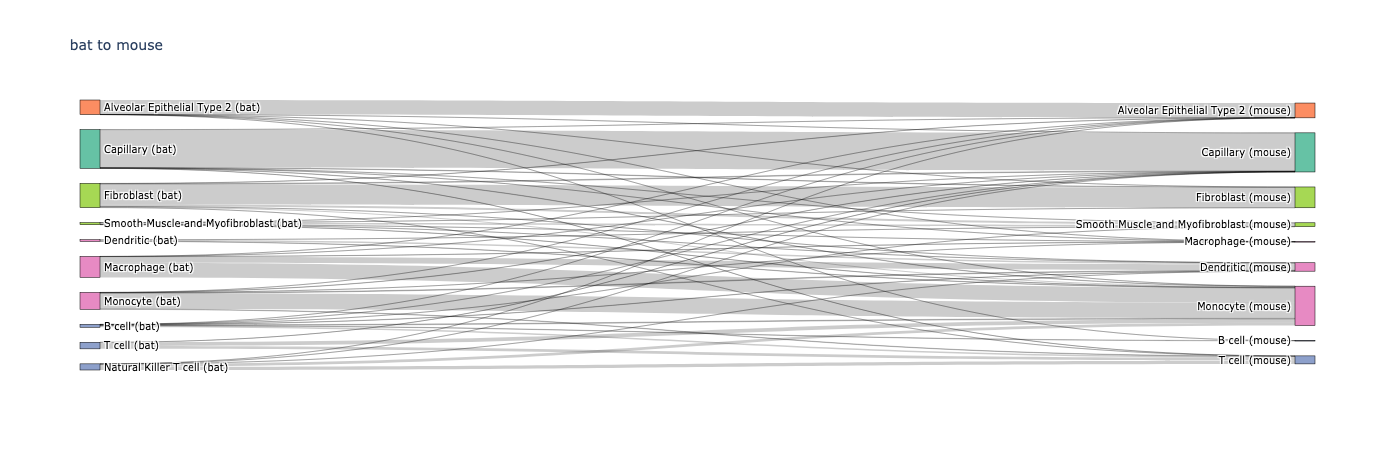

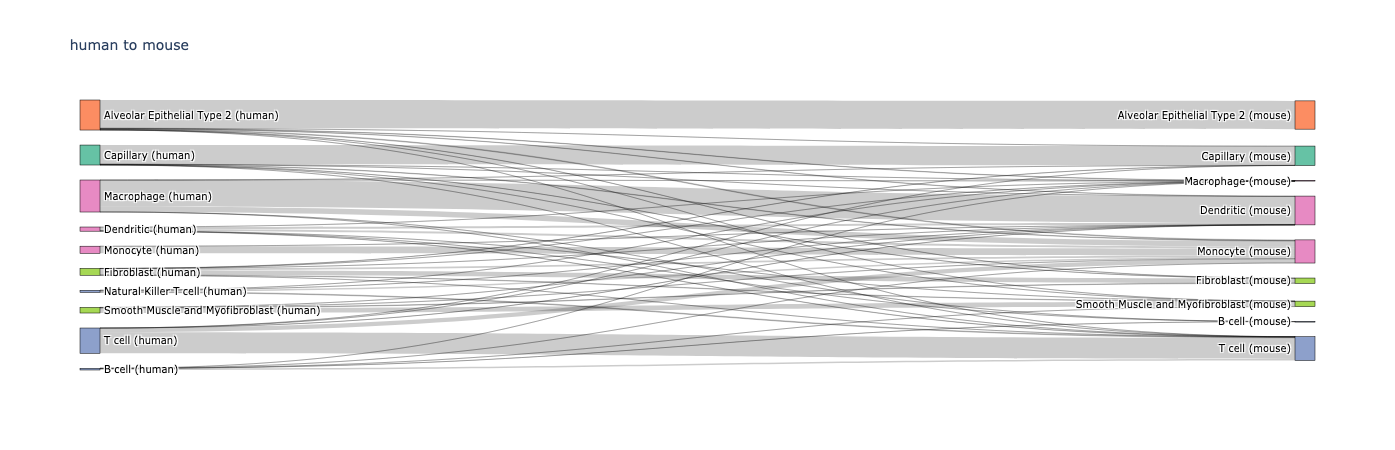

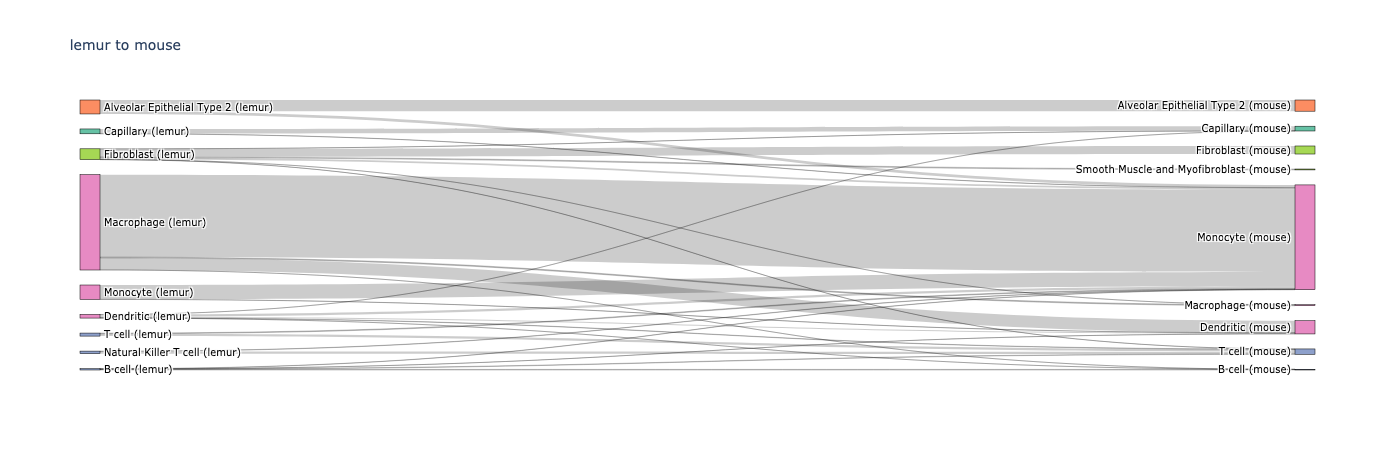

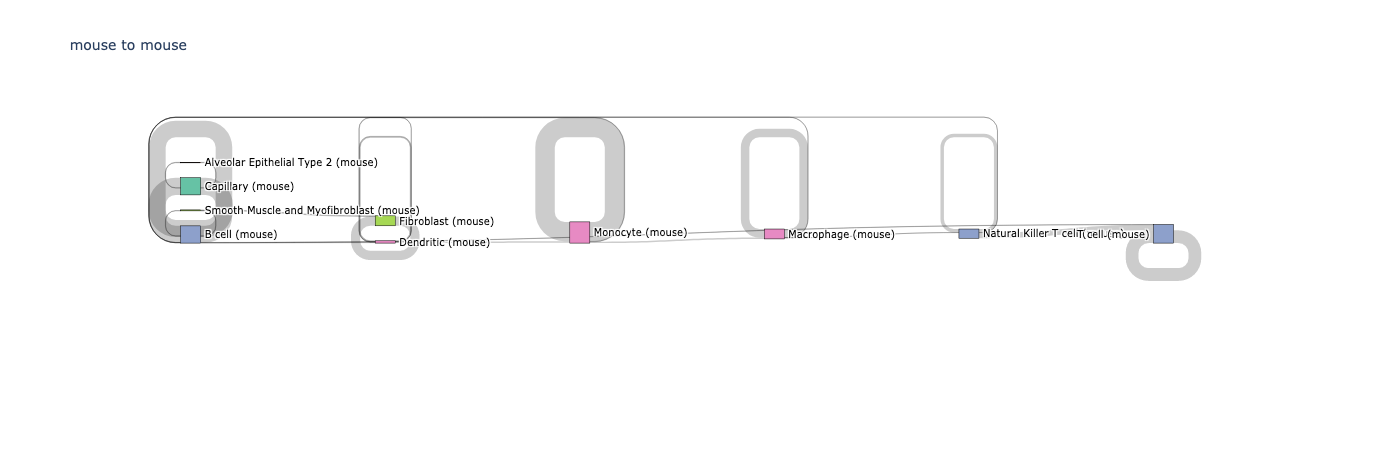

In [37]:
for species, df in predicted_cells.groupby("species"):
    prediction_counts = make_prediction_counts(
        df,
        "groundtruth_celltype",
        "predicted_celltype",
        query=species,
        database="mouse",
    )
    prediction_counts = prediction_counts.sort_values(["ground_truth", "prediction"])

    category_colors = get_celltype_colors(prediction_counts)

    sankey_fig = genSankey(
        prediction_counts,
        cat_cols=["ground_truth", "prediction"],
        node_colors=category_colors,
        value_cols="n_cells",
        title=f"{species} to mouse",
    )
    sankey_fig
    # creating the sankey diagram

    # plotly.offline.plot(sankey_fig, validate=False)

    fig = go.Figure(sankey_fig)
    fig.update_layout(width=300)

    fig.show()

    fig.write_image(os.path.join(figure_folder, f"celltype__{species}.png"), width=650, height=400)

## Do on compartment level

In [38]:
compartment_to_color

{'endothelial': (0.4, 0.7607843137254902, 0.6470588235294118),
 'epithelial': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'lymphoid': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'myeloid': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'stromal': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)}

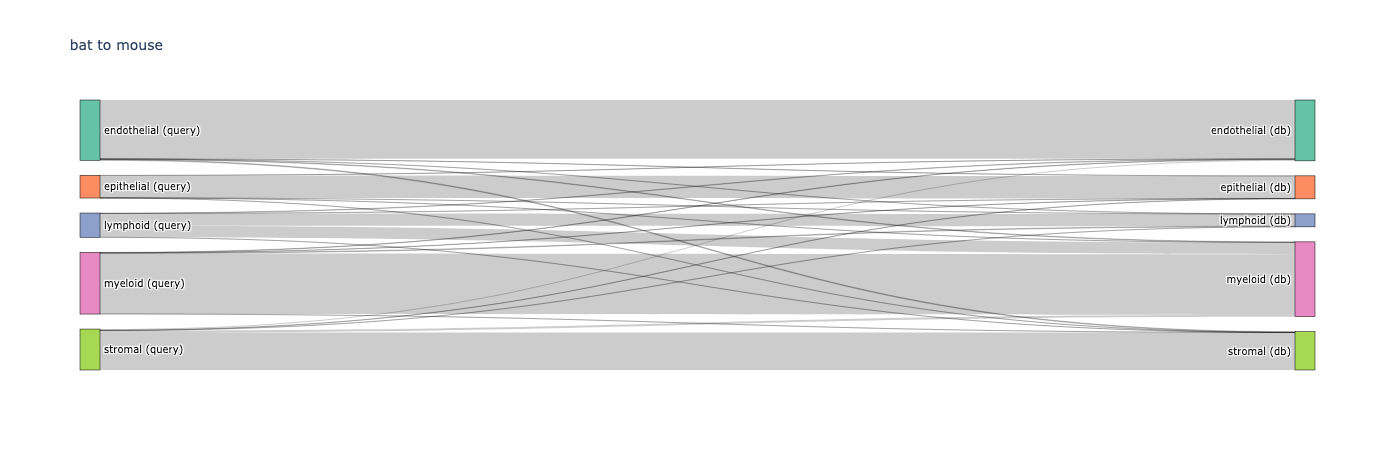

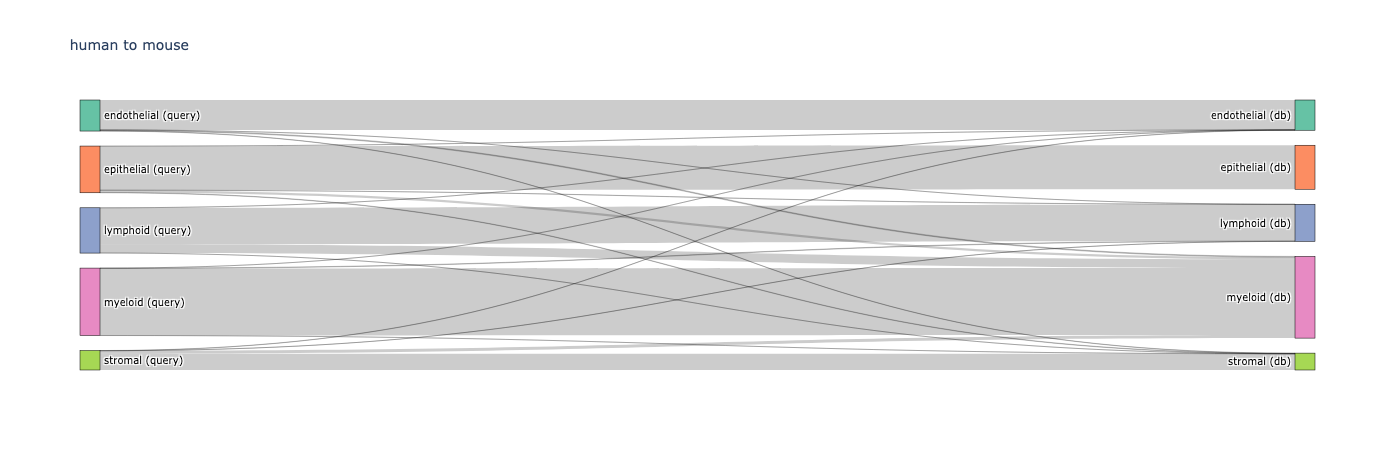

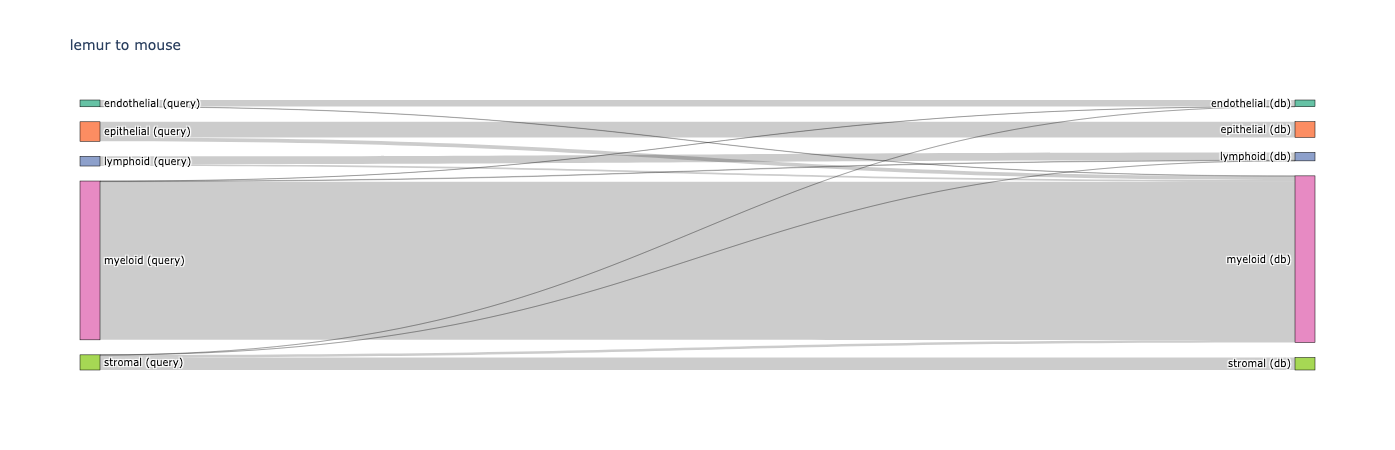

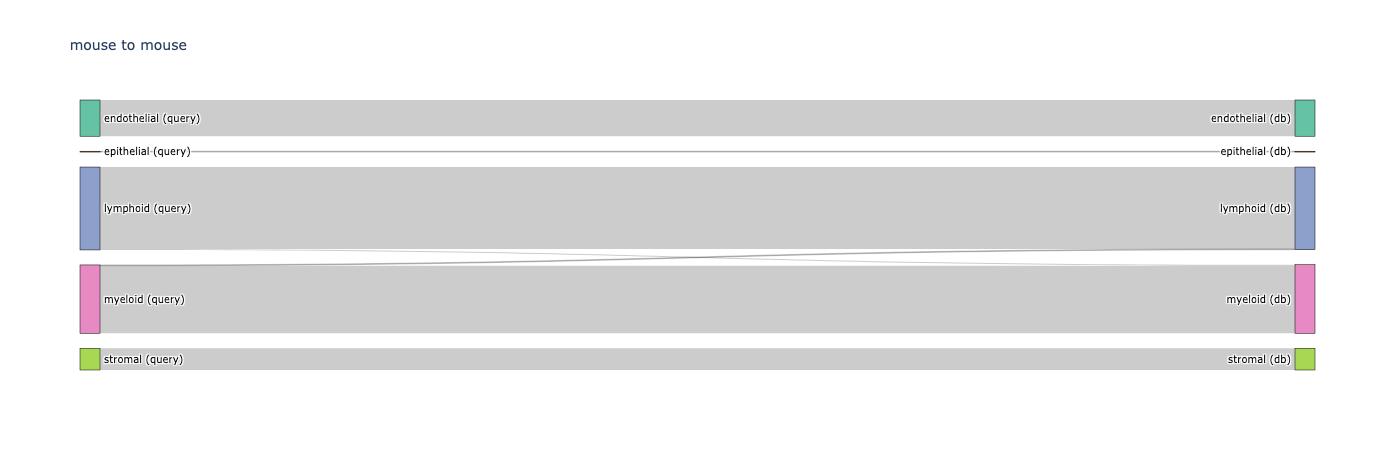

In [39]:
for species, df in predicted_cells.groupby('species'):
    prediction_counts = make_prediction_counts(
        df,
        "groundtruth_compartment",
        "predicted_compartment",
    )
    prediction_counts = prediction_counts.sort_values(['ground_truth', 'prediction'])
    
    compartment_colors = get_compartment_colors(prediction_counts)

    sankey_fig = genSankey(
        prediction_counts,
        cat_cols=["ground_truth", "prediction"],
        node_colors=compartment_colors,
        value_cols="n_cells",
        title=f"{species} to mouse",
    )
    sankey_fig
    # creating the sankey diagram

    # plotly.offline.plot(sankey_fig, validate=False)

    fig = go.Figure(sankey_fig)
    fig.update_layout(width=300)

    fig.show()
    fig.write_image(os.path.join(figure_folder, f"compartment__{species}.png"), width=650, height=400)
